**Лабораторная работа №4**

Студент: Пешков М.Ю. Группа: М8О-109М-23

Задание:



*   Подобрать любую функцию
*   Реализовать Rejection Sampling
*   Реализовать алгоритм Метрополиса-Гастингса



In [ ]:
import numpy as np
import random
import math

from typing import Tuple, Mapping

from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d

In [ ]:
rand = np.random.RandomState(seed=11)

Базовая функция для сэмплирования: функция нормального распределения.

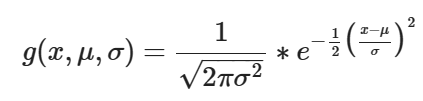

In [ ]:
normal_distr = lambda x: np.e ** (-0.5 * ((x - np.mean(x)) / np.std(x)) ** 2) / (2 * np.pi * np.std(x) ** 2) ** 0.45

In [ ]:
def func(x):
    return np.e ** (-x ** 2 / 2) * (np.sin(6 + x) ** 2 + np.sin(3 * x) ** 2)

In [ ]:
x = np.linspace(-6, 6, 1000)
d_func = [func(dot) for dot in x.tolist()]

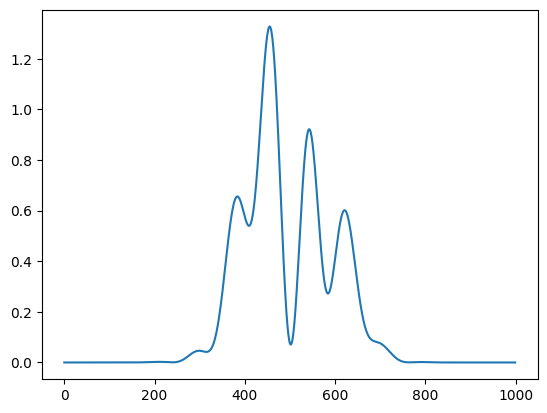

In [ ]:
plt.plot(d_func)
plt.show()

<a id='op2'></a>
## Rejection Sampling

**Rejection Sampling** это средство генерации случайных чисел, принадлежащих определенному распределению.

Чаще всего применяется для семплирования сложных вероятностных распределений, в котором генерация семплов по $f(x)$ происходит с помощью более простого вспомогательного распределения $g(x)$, которое уже известно, как семплировать, и которое удовлетворяет следующему условию: $$\forall x \to f(x) < cg(x) $$
$c > 1$ - константа вероятностного распределения.

Примерная логика работы алгоритма:

1. Взять семпл $x$ по базовому $g(x)$ распределению

2. Выбрать случайное число n из отрезка $[0; cg(x)]$

3. Вычислить $f(x)$

    - Если $n \leq f(x)$, то $x$ добавляется к семплам

    - Если $n > f(x)$, то $x$ отклоняется


4. Алгоритм выбирает точки $[x, n]$ из области под графиком $f(x)$, так происходит сэмплирование.

5. Алгоритм эффективен, когда форма вспомогательной функции $g()$ близка к форме целевой функции $f(x)$.


Хорош, когда размерность выборки невысока и можем подобрать константу с.

In [ ]:
def rejection_sampling(data: np.array, target_func: Mapping, base_func: Mapping,
              size: int = 1000, c: float = 1.) -> Tuple:
    true_x=[]
    true_y=[]
    false_x=[]
    false_y=[]

    # задаем границы
    y_min = min([target_func(dot) for dot in data.tolist()])

    x = rand.uniform(data.min(), data.max(), size=size)
    y = rand.uniform(y_min, c * base_func(x), size=size)

    for i in range(len(x)):
        val = x[i]
        if y[i] <= target_func(val):
            true_x.append(x[i])
            true_y.append(y[i])
        else:
            false_x.append(x[i])
            false_y.append(y[i])

    return x, y, true_x, true_y, false_x, false_y

In [ ]:
x = np.linspace(-6, 6, 1000)
rs_func2 = rejection_sampling(x, func, normal_distr, c=11, size=4000)

In [ ]:
def plot_RS(x, func: Mapping, title: str, true_x, true_y, false_x, false_y, show_density=False):

    y = [func(i) for i in x]

    fig, ax = plt.subplots(figsize=(16,8))
    if show_density:
        plt.hist(rs[2], 15, density=True, color='red', alpha=0.4)
    plt.plot(x, y, color='blue', alpha=0.8)
    plt.scatter(true_x, true_y, s=2, color='green')
    plt.scatter(false_x, false_y, s=1, color='red')


    ax.set_title(f'Rejection Sampling of {title} Function', fontweight='bold')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    plt.show()

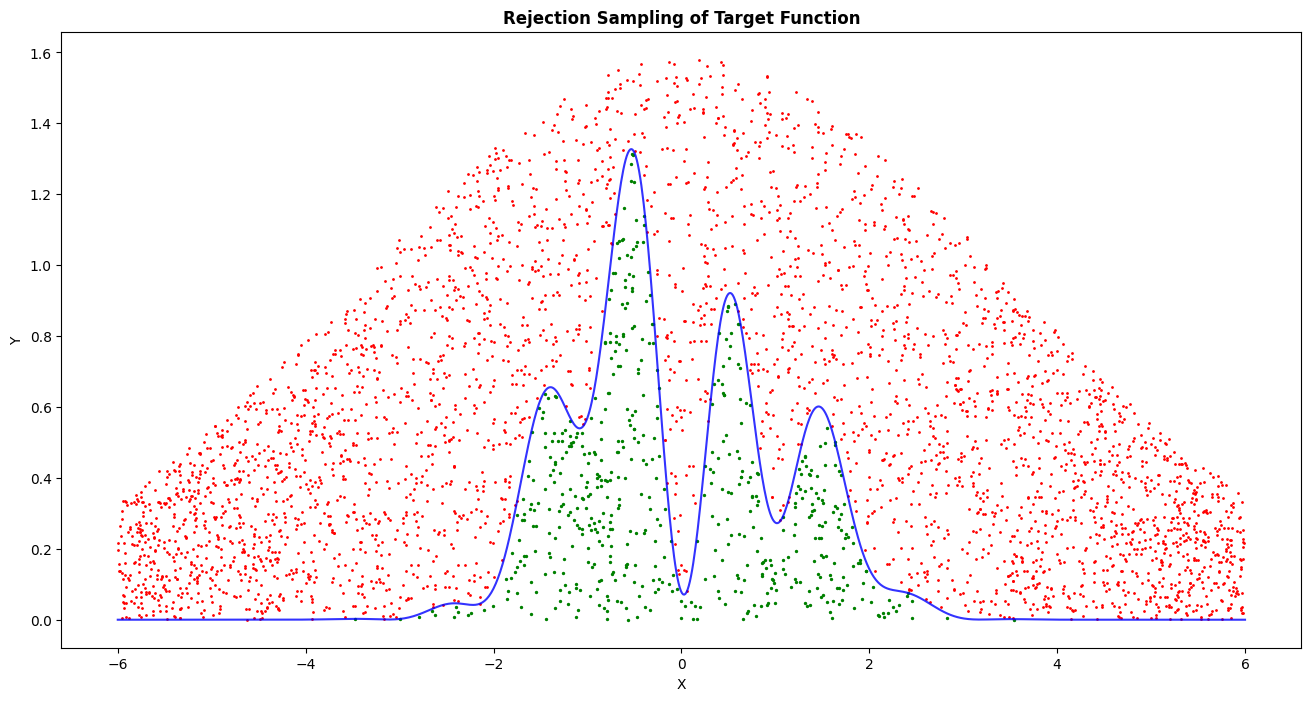

In [ ]:
x = np.linspace(-6, 6, 1000)
plot_RS(x, func, 'Target', rs_func2[2], rs_func2[3], rs_func2[4], rs_func2[5])

<a id='op3'></a>
## MCMC

**Алгоритм Метрополиса-Гастингса** или *цепь Маркова Монте-Карло*, также применяется для сэмплирования. Однако этот метод позволяет сэмплировать любую функцию.

Основан на создании цепи Маркова: на каждом шаге алгоритма новое выбранное значение $x^{t+1}$зависит от предыдущего $x^t$. Он использует вспомогательную функцию $Q(x'|x^t)$, зависящую от $x^t$, для которой легко генерируется выборка. На каждом шаге для этой функции генерируется случайное значение $x'$, а затем с вероятностью $v$, (или с вероятностью 1, если $v > 1$), выбранное значение принимается как новое, иначе оставляется старое.
$$v = \frac{P(x')Q(x^t|x')}{P(x^t)Q(x'|x^t)}$$

Таким образом, алгоритм действует изнутри целевой функции путём построения случайного блуждания под её графиком, переходя от одной точки к другой, и время от времени забирая текущую точку блуждания в качестве сэмпла.

Алгоритм:
- Сгенерировать новое значение p случайным образом между 0 и 1, называем его p' (или p_new).
- Вычислить коэффициент acceptance ratio.
- Сгенерировать другое однородное случайное число от 0 до 1, v.
- Если v < R, принимаем новое значение и заменяем p = p'. В противном случае оставляем текущее значение p.
- Записываем конечное значение p.

In [ ]:
def MH_sampling(data, target_func: Mapping,
               base_func: Mapping, size: int = 1000,
               max_dist: float = .5):
    '''
    Func:
        Реализация Metropolis Hastings
    Args:
        data (np.array): начальный сэт данных
        target_func (Mapping): целевая функция
        base_func (Mapping): вспомогательная функция
        size (int): размер сэмпл выборки
        max_dist (float, optional): максимальная дистанция блуждания

    N - количество точек (int)
    f - функция
    x0 - начальная точка
    Return:
        np.array: накопленная плотность на координату
    '''
    x_prev = rand.uniform(data.min(), data.max())
    samples = [x_prev]

    for i in range(size):
        x_next = rand.normal(x_prev, max_dist)


        val_next = x_next
        val_prev = x_prev


        p_x_next = np.prod(target_func(val_next)) # вычисляет произведение элементов массива (плотность)
        p_x_prev = np.prod(target_func(val_prev))

        q_x_prev_x_next = base_func(np.array(sorted([x_prev, x_next])))[0]
        q_x_next_x_prev = base_func(np.array(sorted([x_next, x_prev])))[0]

        p_q_divider = p_x_next * q_x_prev_x_next  # p то что хотим сэмплировать, q то что умеем
        p_q_denominator = p_x_prev * q_x_next_x_prev

        acceptance_ratio = p_q_divider / p_q_denominator

        if rand.rand() < acceptance_ratio:
            x_prev = x_next

        samples.append(x_prev)

    return np.array(samples)

In [ ]:
def plot_MH(x, func: Mapping, title: str, result_samples):
    if func == func:
        y = [func(i) for i in x]
        bins = 50
    else:
        y = func(x)
        bins = 30

    fig, ax = plt.subplots(figsize=(16,6))
    ax.hist(result_samples, bins, density=True, color='green', alpha=0.2)
    plt.plot(x, y, color='blue', alpha=0.8)


    ax.set_title(f'Metropolis–Hastings Sampling of {title} Function', fontweight='bold')
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')

    plt.show()

In [ ]:
x = np.linspace(-6, 6, 1000)
mhfunc = MH_sampling(x, func, normal_distr)

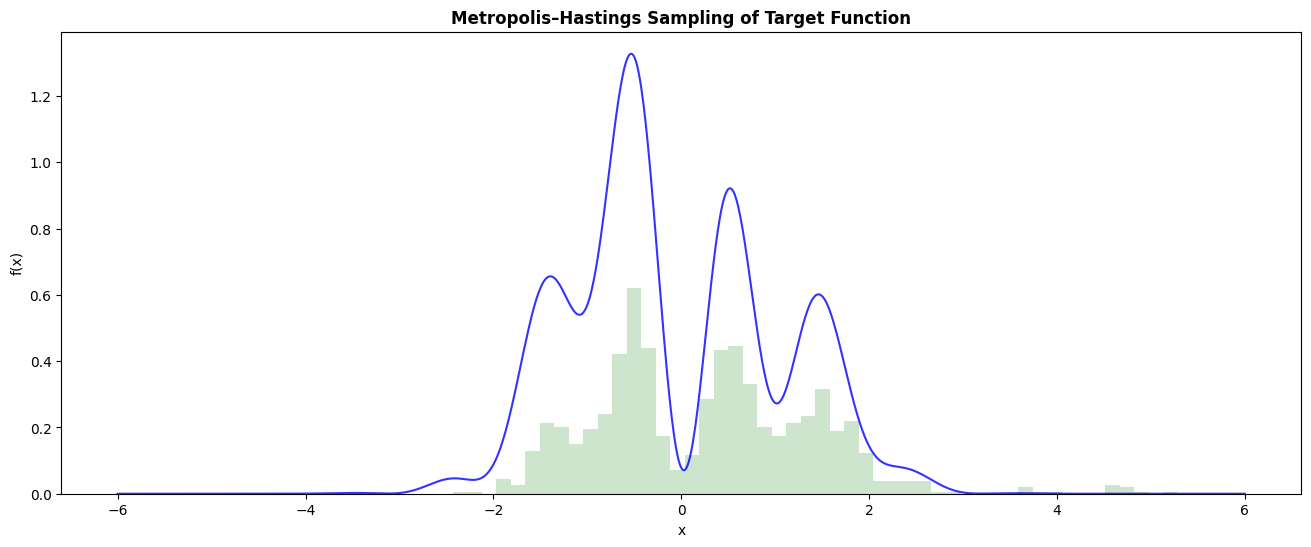

In [ ]:
plot_MH(x, func, 'Target', mhfunc)

*Проба реализации метода Гиббсона

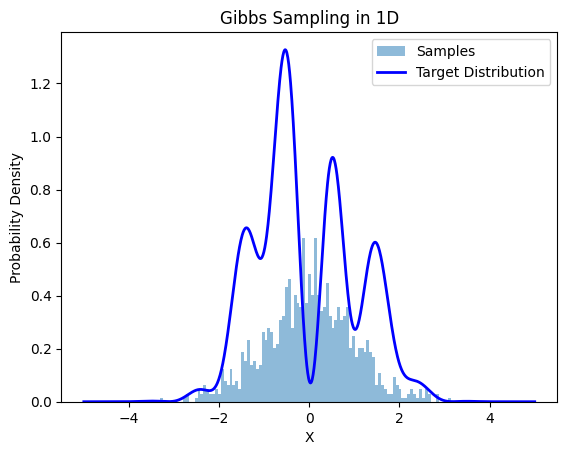

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def target_distribution(x):
    # Пример целевого распределения (можно заменить на другую функцию)
    return np.e ** (-x ** 2 / 2) * (np.sin(6 + x) ** 2 + np.sin(3 * x) ** 2)

def gibbs_sampling_1d(num_samples, burn_in=100):
    samples = np.zeros(num_samples)
    x = 0  # Начальное значение переменной

    for i in range(num_samples + burn_in):
        # Обновление переменной x с учетом текущего значения
        x = np.random.normal(loc=0, scale=1)

        # Сохранение сэмпла после "прогрева" (burn-in)
        if i >= burn_in:
            samples[i - burn_in] = x

    return samples

# Параметры сэмплирования
num_samples = 1000

# Сэмплирование методом Гиббса в одномерном измерении
samples = gibbs_sampling_1d(num_samples)

# Визуализация результатов
plt.hist(samples, bins=100, density=True, alpha=0.5, label='Samples')
x_vals = np.linspace(-5, 5, 1000)
plt.plot(x_vals, target_distribution(x_vals), color='blue', lw=2, label='Target Distribution')
plt.title('Gibbs Sampling in 1D')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.legend()
plt.show()
